In [46]:
import os
import re
import matplotlib
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sys import argv
from scipy.special import factorial
from scipy.stats import poisson
import seaborn as sns
from scipy.special import factorial, gammaln
plt.style.use('seaborn-darkgrid')

### Creo un diccioonario con los nombres de las carpetas y el contenido de ellas, luesgo busco las carpetas que tienen trace names diferentes y las agrupo en distintos diccionarios uno para cada trace names.

### Tambien hay carpetas que tienen archivos bkp, esos si son necesarios habria que tomarlos tambien.

In [5]:
files = {os.path.splitext(k)[0]: {} for k in os.listdir('data/rawData')}

for i,file in enumerate(os.listdir('data/rawData')):
    name=str(os.path.splitext(file)[0])
    f = open(f'data/rawData/{name}/rawdataEMCCD.dat').read().split()
    files[name]=f
# Busco las carpetas que tienen trace names diferentes y las agrupo en distintos
# diccionarios uno para cada trace names.

# Tambien hay carpetas que tienen archivos bkp, esos si son necesarios habria que tomarlos tambien.
l=[]
l1=[]
l2=[]
l3=[]
l4=[]

for i in files:
    if files[i][14]=="866'":
        l.append(int(i))
    elif files[i][13]=="'rsbAx'":
        l1.append(int(i))
    elif files[i][13]=="'rsbRad1'":
        l2.append(int(i))
    elif files[i][13]=="'rsbRad2'":
        l3.append(int(i))
    elif files[i][13]=="'carrier":
        l4.append(int(i))

l=sorted(l)
l1=sorted(l1)
l2=sorted(l2)
l3=sorted(l3)
l4=sorted(l4)
print("Las carpetas con trace names 'without 866' 'with 866 and 854' son:")
print(l)
print('--------------------')
print("Las carpetas con trace names 'rsbAx' 'bsbAx' son:")
print(l1)
print('--------------------')
print("Las carpetas con trace names 'rsbRad1' 'bsbRad1' son:")
print(l2)
print('--------------------')
print("Las carpetas con trace names 'rsbRad2' 'bsbRad2' son:")
print(l3)
print('--------------------')
print("Las carpetas con trace names 'carrier dopp cool' 'carrier SB cool' son:")
print(l4)

# Armo los diccionarios para cada trace name
w866={}
rsbAx={}
rsbRad1={}
rsbRad2={}
cdc={}

# Lleno los diccionarios con sus respectivos archivos
for i in l:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][46:]:
            flo.append(float(j))
        w866[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][46:]:
            flo.append(float(j))
        w866[str(i)]=np.transpose(flo)

for i in l1:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbAx[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbAx[str(i)]=np.transpose(flo)

for i in l2:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbRad1[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbRad1[str(i)]=np.transpose(flo)

for i in l3:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbRad2[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbRad2[str(i)]=np.transpose(flo)

for i in l4:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][46:]:
            flo.append(float(j))
        cdc[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][46:]:
            flo.append(float(j))
        cdc[str(i)]=np.transpose(flo)
        
# Arreglo los archivos de el diccionario file pero tomando desde el dato 46, me voy a comer alguno datos
# para algunos archivos

for i in files.keys():
    val=[]
    for j in files[i][46:]:
        val.append(float(j))
    files[i]=np.transpose(val)


Las carpetas con trace names 'without 866' 'with 866 and 854' son:
[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
--------------------
Las carpetas con trace names 'rsbAx' 'bsbAx' son:
[0, 4, 74, 75, 77, 78, 81, 82, 84, 85]
--------------------
Las carpetas con trace names 'rsbRad1' 'bsbRad1' son:
[1, 5]
--------------------
Las carpetas con trace names 'rsbRad2' 'bsbRad2' son:
[2, 6]
--------------------
Las carpetas con trace names 'carrier dopp cool' 'carrier SB cool' son:
[3, 7, 73, 76, 79, 80, 83]


### Hallando los paramteros $\lambda$
Los archivos estan cargados ahora en forma de arrays

In [52]:
def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return  poisson.pmf(k, lamb)

def poisson_(k, lamb,a,offy,offx,b):
    """poisson pdf, parameter lamb is the fit parameter"""
    return a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy 

def poisson_approx(k, lamb,a,offy,offx,b):
    """poisson pdf, parameter lamb is the fit parameter"""
    return  a*(np.exp( (b*k+offx)*np.log(lamb)-lamb - gammaln *((b*k+offx) + 1)))+offy

def two_poisson(k, lamb,a,offy,offx,b, lamb2,a2,offy2,offx2,b2):
    sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2) 
    return sum_

In [7]:
dicts = [w866,rsbAx,rsbRad1,rsbRad2,cdc]

<ipython-input-52-270c8ee123b8>:14: RuntimeWarning: invalid value encountered in power
  sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2)
<ipython-input-52-270c8ee123b8>:14: RuntimeWarning: overflow encountered in power
  sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2)
<ipython-input-52-270c8ee123b8>:14: RuntimeWarning: invalid value encountered in true_divide
  sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2)
<ipython-input-52-270c8ee123b8>:14: RuntimeWarning: divide by zero encountered in true_divide
  sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2)


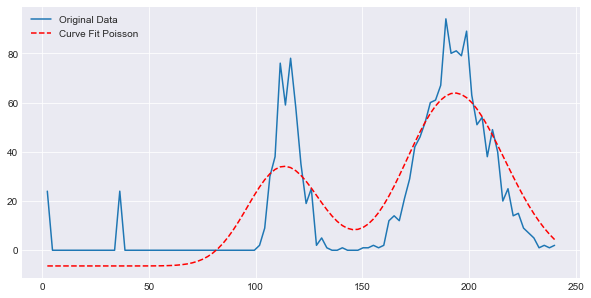

In [98]:
#PRUEBA DE AJUSTE CON UN GRAFICO

entries, bin_edges, patches = plt.hist(rsbAx['4'],bins=int(max(dict_[file])/4))
x = np.delete(bin_edges,0,0)
y = entries

param, param_cov = curve_fit(two_poisson,x,y, p0=[90,10000,220,5,0.5,60,10000,220,10,0.5])
%matplotlib inline
plt.figure(figsize = (10,5))
plt.plot(x,y,label='Original Data')
plt.plot(x,two_poisson(x,param[0],param[1],param[2],param[3],param[4],param[5],param[6],param[7],param[8],param[9]), label =f"Curve Fit Poisson",ls='dashed',color='red') 
plt.legend()
#print(param)

<ipython-input-52-270c8ee123b8>:14: RuntimeWarning: overflow encountered in power
  sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2)
<ipython-input-52-270c8ee123b8>:14: RuntimeWarning: invalid value encountered in true_divide
  sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2200.

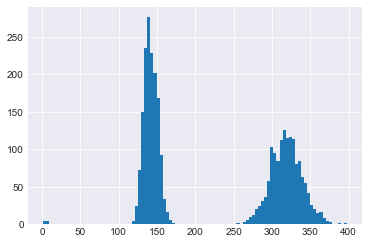

In [99]:
parameters_ = {str(int(os.path.splitext(k)[0])): [] for k in os.listdir('data/rawData')}

for dict_ in dicts:
    for file in dict_:
        data = dict_[file]
        entries, bin_edges, patches = plt.hist(data,bins=int(max(data)/4))
        x = np.delete(bin_edges,0,0)
        y = entries

        param, param_cov = curve_fit(two_poisson,x,y, p0=[90,10000,220,5,0.5,60,10000,220,10,0.5])
        fig = plt.figure(figsize = (10,5))
        plt.plot(x,y,label='Original Data')
        plt.plot(x,two_poisson(x,param[0],param[1],param[2],param[3],param[4],param[5],param[6],param[7],param[8],param[9]), label =f"Curve Fit Poisson",ls='dashed',color='red') 
        plt.legend()
        fig.savefig(f'figs/{file}.png')
        parameters_[file] = param
        
        
        

In [55]:
f = open(f'data/rawData/01/rawdataEMCCD.dat').read()

In [33]:
list_ = []
for i in f.split('\n')[6:]:
    sub_list = [float(n) for n in i.split('\t') if n != '']
    list_.append(sub_list)
    

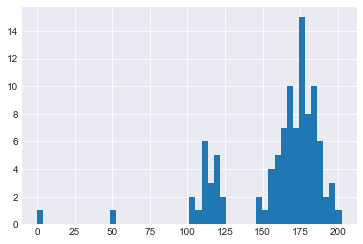

In [39]:
entries, bin_edges, patches = plt.hist(list_[1],bins=int(max(list_[0])/4))